In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from tools import find_multiple_sets
from LagsCreator.LagsCreator import LagsCreator

## Dataset

In [3]:
COUNTRY = "Yemen"

In [4]:
PATH_TO_DATA_FOLDER = "../../Dataset time-series/data/" + COUNTRY + "/"

In [5]:
# Load the dataset of the training sets.
train = pd.read_csv(PATH_TO_DATA_FOLDER + "train.csv", header = [0, 1], index_col = 0)
train.index.name = "Datetime"
train.index = pd.to_datetime(train.index)
freq = "D"
train.index.freq = freq

In [6]:
# Load the dataset of the smoothed training sets.
train_smooth = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train_smooth.index.name = "Datetime"
train_smooth.index = pd.to_datetime(train_smooth.index)
freq = "D"
train_smooth.index.freq = freq

In [7]:
# Load the dataset of the test sets.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [8]:
# Load the dataset of the whole time-series of the fcs indicator.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [9]:
TRAIN = train.copy()

In [10]:
TEST_SIZE = 30
FREQ = TRAIN.index.freq

In [11]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [12]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

In [13]:
# Get the training and test sets.
TRAIN_SETS = find_multiple_sets(train)
TRAIN_SMOOTH_SETS = find_multiple_sets(train_smooth)
TEST_TARGET_SETS = find_multiple_sets(test)

## Forecasting

In [14]:
lags_dict = dict()
# Define lags for each indicator.
lags_dict["3 Months Anomaly (%) Rainfall"] = None
lags_dict["1 Month Anomaly (%) Rainfall"] = None
lags_dict["Cereals and tubers"] = None
lags_dict["Exchange rate (USD/LCU)"] = None
lags_dict["FCS"] = 30
lags_dict["Fatality"] = None
lags_dict["NDVI Anomaly"] = None
lags_dict["Rainfall (mm)"] = None
lags_dict["rCSI"] = None
lags_dict["Lat"] = None
lags_dict["Lon"] = None
lags_dict["Population"] = 0
lags_dict["Ramadan"] = None

In [15]:
import xgboost as xgb

In [16]:
FORECASTING = test.copy()

In [17]:
for h in range(TEST_SIZE):
    X_train_list, y_train_list = list(), list()
    X_test_dict = dict()
    for i, (train, train_smooth) in enumerate(zip(TRAIN_SETS, TRAIN_SMOOTH_SETS)):
        for PROVINCE in PROVINCES:
            creator = LagsCreator(train[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
            X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = True, h = h+1, return_dataframe = True,
                                                                   feature_time = True, validation = False, return_single_level = True, 
                                                                   dtype = np.float64)
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)
            
            creator = LagsCreator(train_smooth[[PROVINCE]], lags_dictionary = lags_dict, target = "FCS")
            X_train, y_train, _, _, X_test = creator.to_supervised(n_out = TEST_SIZE, single_step = True, h = h+1, return_dataframe = True,
                                                                   feature_time = True, validation = False, return_single_level = True, 
                                                                   dtype = np.float64)
            # Add a list of all the training samples of all the provinces together.
            X_train_list.append(X_train)
            y_train_list.append(y_train)
            
            # Add the test sample of the province of the current set into a dictionary.
            X_test_dict[(PROVINCE, i)] = X_test

    X_train = pd.concat(X_train_list)
    y_train = pd.concat(y_train_list)

    print("Training %s samples for the prediction horizon h: %d" % (str(X_train.shape), h+1))
    model = xgb.XGBRegressor(n_estimators = 100, objective = "reg:squarederror")  
    model.fit(X_train, y_train)  

    # Prediction.
    for i, test_set in enumerate(TEST_TARGET_SETS):
        for PROVINCE in PROVINCES:
            X_test = X_test_dict[(PROVINCE, i)]
            y_hat = model.predict(X_test)[0]
            FORECASTING[(PROVINCE, "FCS")].loc[test_set.index[h]] = y_hat

Training (17520, 34) samples for the prediction horizon h: 1
Training (17400, 34) samples for the prediction horizon h: 2
Training (17280, 34) samples for the prediction horizon h: 3
Training (17160, 34) samples for the prediction horizon h: 4
Training (17040, 34) samples for the prediction horizon h: 5
Training (16920, 34) samples for the prediction horizon h: 6
Training (16800, 34) samples for the prediction horizon h: 7
Training (16680, 34) samples for the prediction horizon h: 8
Training (16560, 34) samples for the prediction horizon h: 9
Training (16440, 34) samples for the prediction horizon h: 10
Training (16320, 34) samples for the prediction horizon h: 11
Training (16200, 34) samples for the prediction horizon h: 12
Training (16080, 34) samples for the prediction horizon h: 13
Training (15960, 34) samples for the prediction horizon h: 14
Training (15840, 34) samples for the prediction horizon h: 15
Training (15720, 34) samples for the prediction horizon h: 16
Training (15600, 

In [18]:
# Plot time-series.
TsIP(FORECASTING, target).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…

In [19]:
FORECASTING_TARGET_SETS = find_multiple_sets(FORECASTING)

In [20]:
from sklearn.metrics import mean_squared_error

# Loss.
losses = list()
losses_h = list()
for test_set, forecasting_set in zip(TEST_TARGET_SETS, FORECASTING_TARGET_SETS):
    # Reduce columns to have only the columns of the provinces.
    test_set.columns = test_set.columns.get_level_values(0)
    forecasting_set.columns = forecasting_set.columns.get_level_values(0)
    # Compute losses.
    for PROVINCE in PROVINCES:
        loss = mean_squared_error(test_set[PROVINCE], forecasting_set[PROVINCE])
        losses.append(loss)
        loss_h = mean_squared_error([test_set[PROVINCE]], [forecasting_set[PROVINCE]], multioutput = "raw_values")
        losses_h.append(loss_h)

In [21]:
overall_mse = np.mean(losses)
overall_mse

20.916732733088477

In [22]:
# Load naive model forecasting results.
naive = np.load("../Naive_" + COUNTRY + ".npy")

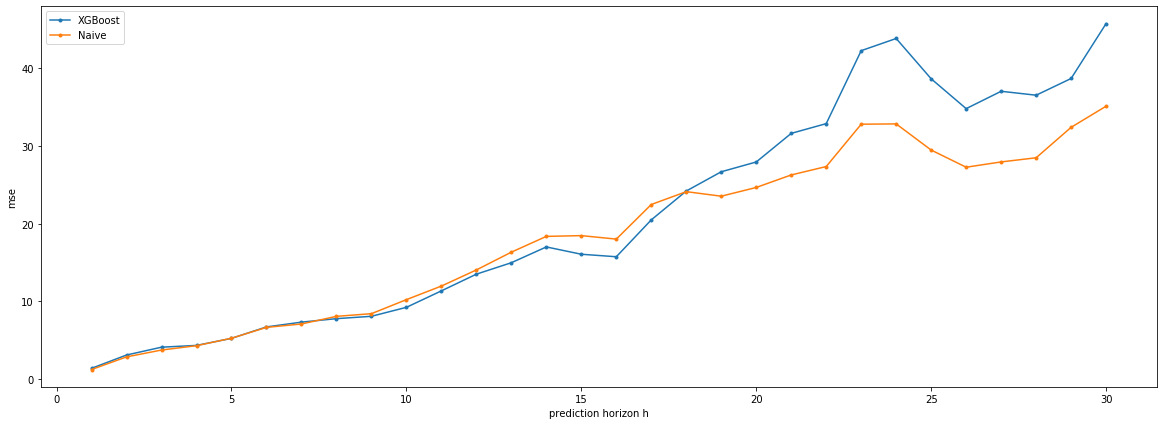

In [23]:
fig, ax = plt.subplots(figsize = (20, 7))
ax.plot(np.arange(1, TEST_SIZE + 1), np.mean(losses_h, axis = 0), ".-", label = "XGBoost")
ax.plot(naive[0], naive[1], ".-", label = "Naive")
ax.set_ylabel("mse", fontsize = 10)
ax.set_xlabel("prediction horizon h", fontsize = 10)
ax.legend();